In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as Axes3D
import numpy as np
import ghalton as gh

from scipy import integrate
from scipy import signal

%matplotlib inline

# Define actual test

Define actual test points for our experiments. Basically a 4-dimensional Halton sequence of however many points we want to test. MFCs are defined in the order `[air, pilot, middle, outer]`.

In [2]:
def mass_flow(V_dot, gas="air"):
    """
    Determine mass flow [g/min] from volumetric flow rate [SLPM].
    
    Args:
        V_dot (float): volumetric flow rate, SLPM
        gas (string, default="air"): either "air" or "methane". Used to set molar mass.
        
    Returns:
        float: mass flow rate of the gas, g/min
    """
    
    mass = {"air": 28.97, "methane": 16.04}  # molar mass dict
    P = 1.  # atmospheric pressure = 1 atm
    R = 82.1  # constant, (cm^3*atm)/(mole*K)
    T = 273.15 + 24  # room temperature, K
    n = 1.  # number of moles
    return V_dot*1000*mass[gas]*P/n/R/T

def vol_flow(m_dot, gas="air"):
    """
    Determine the volumetric flow rate [SLPM] from mass flow rate [g/min].
    
    Args:
        m_dot (float): mass flow rate, g/min
        gas (string, default="air"): either "air" or "methane". Used to set molar mass.
    
    Returns:
        float: volumetric flow rate of the gas, SLPM
    """
    
    mass = {"air": 28.97, "methane": 16.04}  # molar mass dict
    P = 1.  # atmospheric pressure = 1 atm
    R = 82.1  # constant, (cm^3*atm)/(mole*K)
    T = 273.15 + 24  # room temperature, K
    n = 1.  # number of moles
    return m_dot*n*R*T/mass[gas]/P/1000

def equiv_ratio(m_dot_air, m_dot_fuel):
    """
    Determine the equivalence ratio for the given air and fuel flow rates.
    
    Args:
        m_dot_air (float): mass flow rate of air, g/min
        m_dot_fuel (float): mass flow rate of methane, g/min
    
    Returns:
        float: equivalence ratio = actual fuel to air ratio / stoiciometric
    """
    
    AF_stoic = 17.2  # stoiciometric air to fuel ratio
    return AF_stoic*m_dot_fuel/m_dot_air  # FA_actual * AF_stoic

def mf_from_equiv(equiv, m_dot_air):
    """
    Determine the fuel flow rate from desired equivalence ratio and air flow rate.
    
    Args:
        equiv (float): desired equivalence ratio
        m_dot_air (float): mass flow rate of air, g/min
    
    Returns:
        float: total mass flow rate of fuel, g/min
    """
    
    AF_stoic = 17.2  # stoiciometric air to fuel ratio
    return equiv*m_dot_air/AF_stoic

In [8]:
# max_pilot = 2.7  # saturation voltage for pilot MFC
# max_middle = 2.9  # saturation voltage for middle MFC
# max_outer = 1.6  # saturation voltage for outer MFC
max_pilot = 5.0
max_middle = 5.0
max_outer = 5.0
max_air = 4.0  # saturation voltage for air MFC
max_V = np.array([max_air, max_pilot, max_middle, max_outer])
min_factor = 0.06
min_pilot = min_factor*max_pilot  # minimum pilot flow voltage we want, V
min_middle = min_factor*max_middle
min_outer = min_factor*max_outer
min_air = 1.0  # minimum air flow voltage that we want, V
min_V = np.array([min_air, min_pilot, min_middle, min_outer])
air_scale = 500/5  # 500 SLPM of air at 5 V output
# pilot_scale = 100/5  # 100 SLPM of methane at 5 V output
# out_scale = 200/5  # 200 SLPM of methane at 5 V output
pilot_scale = 40/5  # 40 SLPM of methane at 5 V output
out_scale = 40/5  # 40 SLPM of methane at 5 V output
scale_vec = [air_scale, pilot_scale, out_scale, out_scale]
min_equiv = 0.4  # minimum equivalence ratio
max_equiv = 0.9  # maximum equivalence ratio

In [7]:
# Naive approach, just set max flow rates to something shy of their saturation voltages
min_vals = np.array([min_air, 0, 0, 0])  # minimum input voltage per MFC
max_vals = np.array([max_air, max_pilot/2, max_middle/2, max_outer/2])  # reduce max fuel beceause they all share a source
print(max_vals)
max_flow = np.multiply(max_vals, scale_vec)
print(max_flow)
print("Total fuel flow rate = {} SLPM".format(sum(max_flow[1:])))
print("Max flow equivalence ratio = {}".format(equiv_ratio(mass_flow(max_flow[0]), mass_flow(sum(max_flow[1:])))))

[ 4.   2.5  2.5  2.5]
[ 800.   50.   50.   50.]
Total fuel flow rate = 150.0 SLPM
Max flow equivalence ratio = 3.225


Three fuel lines add up to desired fuel flow rate?	True


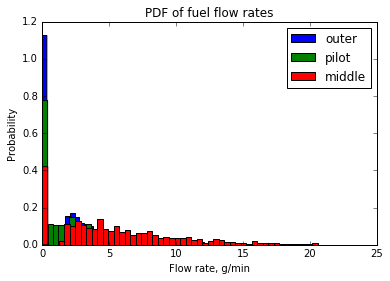

Maximum equiv. ratio: 0.8987505206164099 at 162.40234375 SLPM air and 14.108554606312198 SLPM fuel
Minimum equiv. ratio: 0.4002082465639317 at 224.80468749999994 SLPM air and 21.210922704646734 SLPM fuel
Maximum total fuel flow: 36.1630543495971 SLPM
Minimum total fuel flow: 4.518221605150232 SLPM
Maximum flow rates per line: [ 399.4140625    30.69638232   31.30618326   26.35485851] SLPM
Minimum flow rates per line: [ 100.29296875    0.            0.            0.        ] SLPM


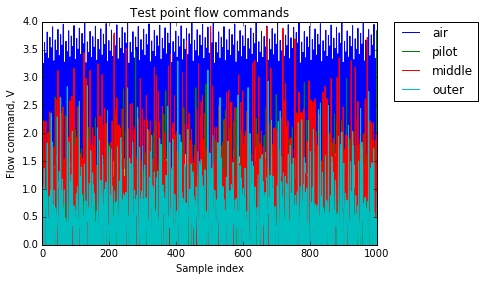

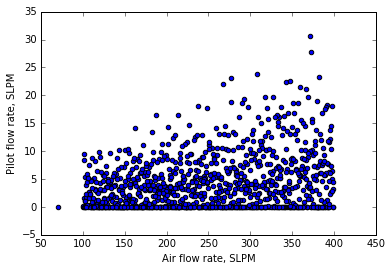

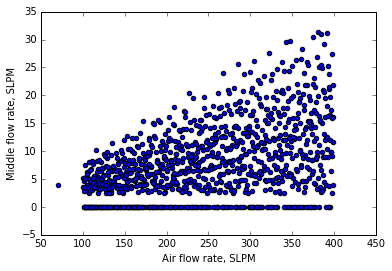

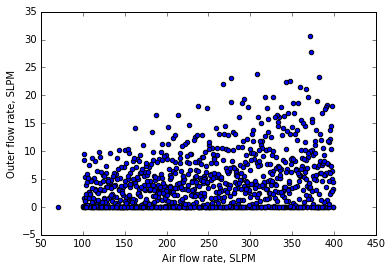

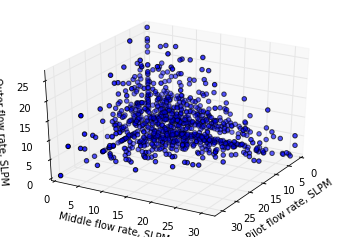

In [53]:
# Define flags
_print = False
_plot = True
_save = False

# Equivalence ratio too high: try different approach
min_vals = np.array([min_air, 0, 0, min_equiv])
max_vals = np.array([max_air, 1, 1, max_equiv])
max_flow = np.multiply(max_V, scale_vec)
min_flow = np.multiply(min_V, scale_vec)
num_train = 1000  # number of points to test
sequence = gh.Halton(4)  # 4-dimensional Halton sequence
ratios = sequence.get(num_train)  # get however many points we want from the sequence
ratios = np.array([np.multiply(point, max_vals - min_vals) + min_vals for point in ratios])

if _print:
    print(ratios)
    
air_flow = mass_flow(air_scale*ratios[:,0], "air")  # g/min
fuel_flow = mf_from_equiv(ratios[:,3], air_flow)  # total fuel flow, g/min

middle_flow = np.minimum(np.multiply(fuel_flow, ratios[:,1]), mass_flow(max_flow[2], "methane"))  # g/min
middle_flow[middle_flow < mass_flow(min_flow[2], "methane")] = 0.  # set flow rates below cutoff rate to zero
pilot_flow = np.minimum(np.multiply(fuel_flow-middle_flow, ratios[:,2]), mass_flow(max_flow[1], "methane"))  #g/min
pilot_flow[pilot_flow < mass_flow(min_flow[1], "methane")] = 0.  # set flow rates below cutoff rate to zero
outer_flow = np.minimum(fuel_flow-pilot_flow-middle_flow, mass_flow(max_flow[3], "methane"))  # g/min
pilot_flow[outer_flow < mass_flow(min_flow[3], "methane")] += outer_flow[outer_flow < mass_flow(min_flow[3], "methane")]
outer_flow[outer_flow < mass_flow(min_flow[3], "methane")] = 0.  # set flow rates below cutoff rate to zero

print("Three fuel lines add up to desired fuel flow rate?\t{}".format(all(fuel_flow -(pilot_flow + middle_flow + outer_flow) < 1e-4)))

# Plot normalized flow rate pdfs
if _plot:
    plt.hist(outer_flow, bins=50, normed=True)
    plt.hist(pilot_flow, bins=50, normed=True)
    plt.hist(middle_flow, bins=50, normed=True)
    plt.legend(["outer", "pilot", "middle"])
    plt.xlabel("Flow rate, g/min")
    plt.ylabel("Probability")
    plt.title("PDF of fuel flow rates")
    plt.show()

air_flow = vol_flow(air_flow, "air")  # SLPM
middle_flow = vol_flow(middle_flow, "methane")  # SLPM
pilot_flow = vol_flow(pilot_flow, "methane")  # SLPM
outer_flow = vol_flow(outer_flow, "methane")  # SLPM

training = np.vstack((air_flow, pilot_flow, middle_flow, outer_flow)).T
training = np.divide(training, scale_vec)  # Volts
training = np.insert(training, 0, [0.7, 0.0, 0.5, 0.0], axis=0)  # insert voltages for reignite point
rates = np.multiply(training, scale_vec)

max_index = np.argmax(ratios[:,3])
min_index = np.argmin(ratios[:,3])
print("Maximum equiv. ratio: {} at {} SLPM air and {} SLPM fuel".format(ratios[max_index,3], rates[max_index,0], sum(rates[max_index,1:])))
print("Minimum equiv. ratio: {} at {} SLPM air and {} SLPM fuel".format(ratios[min_index,3], rates[min_index,0], sum(rates[min_index,1:])))
print("Maximum total fuel flow: {} SLPM".format(max([sum(rate[1:]) for rate in rates[1:]])))
print("Minimum total fuel flow: {} SLPM".format(min([sum(rate[1:]) for rate in rates[1:]])))
print("Maximum flow rates per line: {} SLPM".format(np.max(rates[1:], axis=0)))
print("Minimum flow rates per line: {} SLPM".format(np.min(rates[1:], axis=0)))

if _print:
    flow_rates = np.multiply(training, scale_vec)
    print(training)

if _plot:
    plt.figure()
    plt.plot(training)
    plt.legend(["air", "pilot", "middle", "outer"], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.xlabel("Sample index")
    plt.ylabel("Flow command, V")
    plt.title("Test point flow commands")
    plt.show()
    
    plt.figure()
    plt.scatter(rates[:,0], rates[:,1])
    plt.xlabel("Air flow rate, SLPM")
    plt.ylabel("Pilot flow rate, SLPM")
    plt.show()
    
    plt.figure()
    plt.scatter(rates[:,0], rates[:,2])
    plt.xlabel("Air flow rate, SLPM")
    plt.ylabel("Middle flow rate, SLPM")
    plt.show()
    
    plt.figure()
    plt.scatter(rates[:,0], rates[:,1])
    plt.xlabel("Air flow rate, SLPM")
    plt.ylabel("Outer flow rate, SLPM")
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')  # define 3D plot object
    ax.scatter(rates[:,1], rates[:,2], rates[:,3])
    ax.set_xlim3d(0, 32)  # set the axis limits
    ax.set_ylim3d(0, 32)
    ax.set_zlim3d(0, 27)
    ax.set_xlabel("Pilot flow rate, SLPM")
    ax.set_ylabel("Middle flow rate, SLPM")
    ax.set_zlabel("Outer flow rate, SLPM")
    ax.view_init(30, 30)  # rotate the view
    plt.show()

if _save:
    np.savetxt("Set_points/state_sequence_{}.txt".format(num_train), training, delimiter=":")

# Check points using the sphere
Try to implement a test that checks whether points are inside/outside of a hypersphere and plots the results.

In [4]:
def oneSphere(point, radius=1.0):
    """
    Checks whether points are inside or outside of a hypersphere.
    
    Args:
        point (double) array representing test condition
        radius (double, default=1.0) radius of hypersphere to test
    
    Return:
        1 if point is outside of the sphere (good)
        -1 if point is inside of or on the sphere (bad)
    """
    
    return 1 if sum([num**2 for num in point]) > radius**2 else -1

In [5]:
def threeSphere(point, radius=0.5):
    """
    Checks whether points are inside or outside of any one of four hyperspheres.
    
    Args:
        point (double) array representing test condition
        radius (double, default=0.5) radius of hyperspheres to test
    
    Return:
        1 if point is outside of the sphere (good)
        -1 if point is inside of the sphere (bad)
    """
    
    r2 = radius**2
    test0 = (point[0] - 1.0)**2 + sum(num**2 for num in point[1:])
    test1 = (point[1] - 1.0)**2 + point[0]**2 + point[2]**2
    test2 = (point[2] - 1.0)**2 + sum(num**2 for num in point[:-1])
    return -1 if (test0 <= r2 or test1 <= r2 or test2 <= r2) else 1

In [6]:
def map_states(state, offset=0.5, scale=3.0):
    return (state - offset)*scale

In [7]:
# Define test points as Halton sequence
sequence = gh.Halton(3)  # 3-dimensional Halton sequence
training = sequence.get(2000)  # first 1000 points of the Halton sequence
testing = sequence.get(2000) # next 2000 points of the Halton sequence

In [8]:
training = np.array([map(map_states, point) for point in training])
testing = np.array([map(map_states, point) for point in testing])
print(training)

[[ 0.         -0.5        -0.9       ]
 [-0.75        0.5        -0.3       ]
 [ 0.75       -1.16666667  0.3       ]
 ..., 
 [-0.14208984 -1.41495199  0.87888   ]
 [ 1.35791016 -0.41495199  1.47888   ]
 [-1.36083984  0.58504801 -1.49232   ]]


In [9]:
bad = []
for point in training:
    if threeSphere(point) <= 0:
        bad.append(point)

In [10]:
b1, b2, b3 = zip(*bad)

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


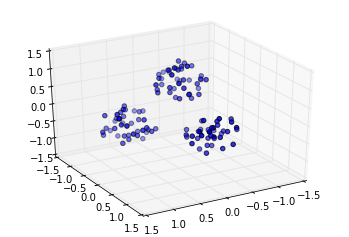

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # define 3D plot object
ax.scatter(b1, b2, b3)
ax.set_xlim3d(-1.5, 1.5)  # set the axis limits
ax.set_ylim3d(-1.5, 1.5)
ax.set_zlim3d(-1.5, 1.5)
ax.view_init(30, 60)  # rotate the view
plt.show()

# Define an SVM classifier

In [12]:
from sklearn import svm

In [158]:
def svn_transform(point):
    """
    Define the nonlinear map to a higher order SVN vector space.
    
    Inputs:
        point (double list) double-valued list representing the state to transform
        
    Returns:
        the list [point, point**2, point**3, combinations of point[i]*point[j], combos of point[i]+point[j]]

    """
    
    combos = list(it.combinations_with_replacement(point, 2))
    return list(it.chain(point, map(lambda a: a**2, point), map(lambda a: a**3, point), map(lambda a: a[0]*a[1], combos), map(lambda a: a[0]+a[1], combos)))

In [159]:
classifier = svm.SVC()
classifier.class_weight="auto"

In [160]:
classifier.fit([svn_transform(point) for point in training], [threeSphere(point) for point in training])

SVC(C=1.0, cache_size=200, class_weight='auto', coef0=0.0, degree=3,
  gamma=0.0, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

In [161]:
predicted = [point for point in testing if classifier.predict(svn_transform(point)) <= 0]
len(predicted)

393

In [162]:
p1, p2, p3 = zip(*predicted)

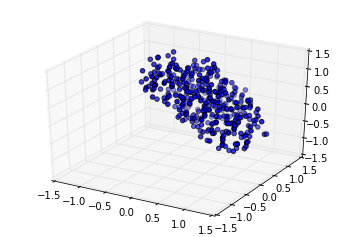

In [163]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p1, p2, p3)
ax.set_xlim3d(-1.5, 1.5)
ax.set_ylim3d(-1.5, 1.5)
ax.set_zlim3d(-1.5, 1.5)
plt.show()

In [164]:
actual = [point for point in testing if oneSphere(point) <= 0]
len(actual)

320

# Develop the sampling dynamics
* Move in a straight line between points, or with 1st/2nd order dynamics.
* Maybe allow myself the ability to switch between different models (linear, 1st order, 2nd order, etc.).

In [165]:
import itertools as it

In [166]:
def sample(points, mode="linear"):
    if mode is "linear":
        samples = []
        for point1, point2 in zip(points[:-2], points[1:]):  # grab point and next point until end
            for point in zip(*map(lambda a,b: np.linspace(a, b, 10, endpoint=False), point1, point2)):  # line between points
                samples.append(point)  # add points on line to sample set
        return samples

In [167]:
samples = sample(training[:500])
samples = np.array(samples)
print(samples)

[[ 0.         -0.5        -0.9       ]
 [-0.075      -0.4        -0.84      ]
 [-0.15       -0.3        -0.78      ]
 ..., 
 [ 0.48164063 -0.3473251   1.3104    ]
 [ 0.63164062 -0.2473251   1.3704    ]
 [ 0.78164062 -0.1473251   1.4304    ]]


In [168]:
classifier = svm.SVC()
classifier.class_weight="auto"
classifier.fit([svn_transform(point) for point in samples], [threeSphere(point) for point in samples])

SVC(C=1.0, cache_size=200, class_weight='auto', coef0=0.0, degree=3,
  gamma=0.0, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

In [169]:
predicted = [point for point in testing if classifier.predict(svn_transform(point)) <= 0]
len(predicted)

280

In [170]:
p1, p2, p3 = zip(*predicted)

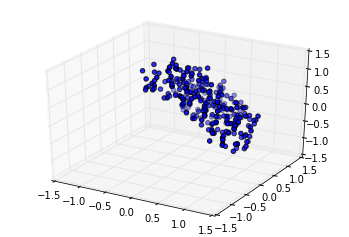

In [171]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p1, p2, p3)
ax.set_xlim3d(-1.5, 1.5)
ax.set_ylim3d(-1.5, 1.5)
ax.set_zlim3d(-1.5, 1.5)
plt.show()

# Try it with ELM
## Start with kernel ELM
The SVM approach seems to be hitting some snags. I think I need to transform my feature vectors (states) into a higher dimensional space so that a single hyperplane can separate all regions. Currently I am keeping in the same space, so I am only really able to separate a single blob.

The ELM might make this a bit easier. Trying to figure out how to use that library now so that I don't need to roll my own.

In [172]:
import elm

In [187]:
params = ["linear", 5, []]  # kernel function, default coeff. of regularization, kernel fcn. args.
elmk = elm.ELMKernel(params)
# elmk = elm.ELMKernel()

In [188]:
training_matrix = np.array([np.insert(svn_transform(point), 0, threeSphere(point)) for point in samples])
print(training_matrix)

[[ 1.          0.         -0.5        ..., -1.         -1.4        -1.8       ]
 [ 1.         -0.075      -0.4        ..., -0.8        -1.24       -1.68      ]
 [ 1.         -0.15       -0.3        ..., -0.6        -1.08       -1.56      ]
 ..., 
 [ 1.          0.48164063 -0.3473251  ..., -0.69465021  0.9630749   2.6208    ]
 [ 1.          0.63164062 -0.2473251  ..., -0.49465021  1.1230749   2.7408    ]
 [ 1.          0.78164062 -0.1473251  ..., -0.29465021  1.2830749   2.8608    ]]


In [189]:
np.count_nonzero(training_matrix[:, 0] - 1)  # count number of "bad" points in the training set

502

In [190]:
elmk_train = elmk.train(training_matrix)
elmk_train.print_errors()


+----------+-------------+
| Error    | Value       |
+----------+-------------+
| accuracy | 0.43554217  |
| hr       | 0.87630522  |
| hr+      | 0.89683518  |
| hr-      | 0.0         |
| mae      | 0.59272526  |
| mape     | 59.27252619 |
| me       | 0.22783065  |
| mpe      | 48.50215242 |
| mse      | 0.48501942  |
| rmse     | 0.69643336  |
| std      | 0.65811292  |
+----------+-------------+



In [177]:
testing_matrix = np.array([np.insert(svn_transform(point), 0, threeSphere(point)) for point in testing])
print(testing_matrix)

[[ 1.          0.13916016 -1.08161866 ..., -2.16323731 -1.97393866 -1.78464   ]
 [ 1.         -0.61083984 -0.08161866 ..., -0.16323731 -0.37393866 -0.58464   ]
 [ 1.          0.88916016  0.91838134 ...,  1.83676269  1.22606134  0.61536   ]
 ..., 
 [ 1.         -0.07104492  0.55669867 ...,  1.11339735  1.43865067
   1.763904  ]
 [ 1.          1.42895508 -1.10996799 ..., -2.21993599  0.37198401
   2.963904  ]
 [ 1.         -1.43041992 -0.10996799 ..., -0.21993599 -1.59921599
  -2.978496  ]]


In [178]:
np.count_nonzero(testing_matrix[:, 0] - 1)  # count number of "bad" points in the testing set

121

In [191]:
elmk_test = elmk.test(testing_matrix)
elmk_test.print_errors()


+----------+-------------+
| Error    | Value       |
+----------+-------------+
| accuracy | 0.577       |
| hr       | 0.9355      |
| hr+      | 0.93925703  |
| hr-      | 0.0         |
| mae      | 0.51608584  |
| mape     | 51.60858427 |
| me       | -0.16288646 |
| mpe      | 0.81501466  |
| mse      | 0.43430689  |
| rmse     | 0.65901964  |
| std      | 0.63857254  |
+----------+-------------+



In [192]:
elmk_test.predicted_targets

array([ 1.22004534,  0.36061562,  0.58748945, ...,  0.24979185,
        2.31907289,  2.33406498])

In [195]:
elmk_predicted = testing[elmk_test.predicted_targets <= 0.5]  # find points in testing set where elm predicts "bad"
len(elmk_predicted)

381

In [196]:
p1, p2, p3 = zip(*elmk_predicted)

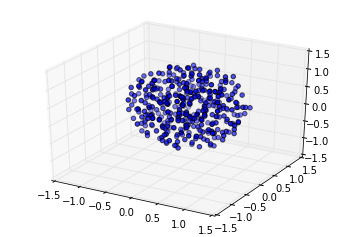

In [197]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p1, p2, p3)
ax.set_xlim3d(-1.5, 1.5)
ax.set_ylim3d(-1.5, 1.5)
ax.set_zlim3d(-1.5, 1.5)
plt.show()

## Try it with a randomly initialized ELM instead of the kernel ELM

In [152]:
elmr = elm.ELMRandom()

In [153]:
elmr_train = elmr.train(training_matrix)
elmr_train.print_errors()


+----------+-------------+
| Error    | Value       |
+----------+-------------+
| accuracy | 0.82891566  |
| hr       | 0.90823293  |
| hr+      | 0.90772663  |
| hr-      | 0.95918367  |
| mae      | 0.2992705   |
| mape     | 29.9270503  |
| me       | -6.017e-05  |
| mpe      | 26.32938818 |
| mse      | 0.23909549  |
| rmse     | 0.48897391  |
| std      | 0.48897391  |
+----------+-------------+



In [154]:
elmr_test = elmr.test(testing_matrix)
elmr_test.print_errors()


+----------+-------------+
| Error    | Value       |
+----------+-------------+
| accuracy | 0.871       |
| hr       | 0.9445      |
| hr+      | 0.94466801  |
| hr-      | 0.91666667  |
| mae      | 0.24075323  |
| mape     | 24.07532294 |
| me       | 0.00672345  |
| mpe      | 16.56483938 |
| mse      | 0.1651405   |
| rmse     | 0.40637482  |
| std      | 0.4063192   |
+----------+-------------+



In [155]:
elmr_predicted = testing[elmr_test.predicted_targets <= 0.5]  # find points in testing set where elm predicts "bad"
len(elmr_predicted)

232

In [156]:
p1, p2, p3 = zip(*elmr_predicted)

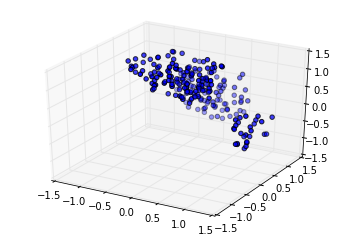

In [157]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p1, p2, p3)
ax.set_xlim3d(-1.5, 1.5)
ax.set_ylim3d(-1.5, 1.5)
ax.set_zlim3d(-1.5, 1.5)
plt.show()

# Experiment Model
* MFCs
* Dynamic pressure transducers
* Static pressure transducer
* Flame
* Combustion chamber
* Controller

In [76]:
# Try the scipy.integrate.ode example
y0, t0 = [1.0j, 2.0], 0

def f(t, y, arg1):
    return [1j*arg1*y[0] + y[1], -arg1*y[1]**2]
def jac(t, y, arg1):
    return [[1j*arg1, 1], [0, -arg1*2*y[1]]]

r = integrate.ode(f, jac).set_integrator('zvode', method='bdf', with_jacobian=True)
r.set_initial_value(y0, t0).set_f_params(2.0).set_jac_params(2.0)
t1 = 10
dt = 1
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    print("{}\t{}".format(r.t, r.y))

1.0	[-0.71038232+0.23749653j  0.40000271+0.j        ]
2.0	[ 0.19098503-0.52359246j  0.22222356+0.j        ]
3.0	[ 0.47153208+0.52701229j  0.15384681+0.j        ]
4.0	[-0.61905937+0.30726255j  0.11764744+0.j        ]
5.0	[ 0.02340997-0.61418799j  0.09523835+0.j        ]
6.0	[ 0.58643071+0.339819j  0.08000018+0.j      ]
7.0	[-0.52070105+0.44525141j  0.06896565+0.j        ]
8.0	[-0.15986733-0.61234476j  0.06060616+0.j        ]
9.0	[ 0.64850462+0.15048982j  0.05405414+0.j        ]
10.0	[-0.38404699+0.56382299j  0.04878055+0.j        ]


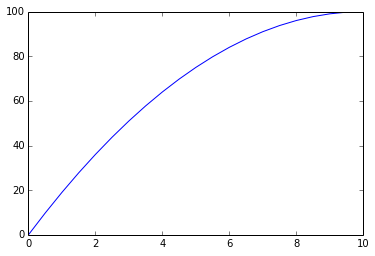

In [109]:
# Try to get scipy.integrate.odeint to work with a simple example
y0 = 0.0
t0 = 0
t_array = np.arange(t0, 10, 0.5)

def f(t, y, u, K, tau):
    return K*u/tau - y/tau
    # return -y/0.5

y_response = integrate.odeint(lambda t, y, u: f(t, y, u, 10.0, 0.5), y0, t_array, (1.0,))
plt.plot(t_array, y_response)

In [112]:
# Try using the object oriented version with my function
r = integrate.ode(lambda t, y, u: f(t, y, u, 10.0, 0.5)).set_integrator("dopri5")
r.set_initial_value(y0, t0).set_f_params(1.0)
t1 = 10
dt = 0.5
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    print("{}\t{}".format(r.t, r.y))

0.5	[ 6.32120537]
1.0	[ 8.64664684]
1.5	[ 9.50212891]
2.0	[ 9.81684298]
2.5	[ 9.9326201]
3.0	[ 9.97521213]
3.5	[ 9.99088089]
4.0	[ 9.99664523]
4.5	[ 9.99876564]
5.0	[ 9.99954559]
5.5	[ 9.9998328]
6.0	[ 9.99993842]
6.5	[ 9.99997732]
7.0	[ 9.99999164]
7.5	[ 9.99999692]
8.0	[ 9.99999887]
8.5	[ 9.99999958]
9.0	[ 9.99999985]
9.5	[ 9.99999994]
10.0	[ 9.99999998]


In [105]:
def my_ode(t, y, u, K, tau):
    """First order general ODE."""
    
    return K*u/tau - y/tau  # dydt

class MFC:
    """
    Defines a mass flow controller with given gain, time constant, time delay, and
    flow rate.
    """
    def __init__(self, mfc_ode, y0):
        """Constructor."""
        
        self.ode = mfc_ode
        self.state = np.array(y0)
        self.time = 0.0
        
    def update(self, input_val, t_step, t_end):
        """Update the function's response."""
        
        t_array = np.arange(self.time, t_end, t_step)
        print(t_array)
        y_response = integrate.odeint(self.ode, self.state, t_array, (input_val,))
        self.state = y_response[-1]
        self.time = t_end
        return [t_array, y_response]

In [106]:
# Test defining multiple MFCs with different parameters.
K_list = [10.0, 5.0]
tau_list = [0.5, 1.4]
mfc_list = []

my_mfc = MFC(lambda t, y, u: my_ode(t, y, u, 10.0, 0.5), 0.0)

In [107]:
# Try to simulate the MFCs in the list and plot the results
dt = 0.5
t_end = 10.0

t_array, response = my_mfc.update(1.0, dt, t_end)

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5]


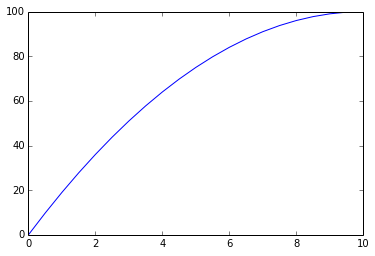

In [108]:
plt.plot(t_array, response)

In [2]:
class Flame:
    """
    Defines the flame dynamics and functions for updating the flame response.
    """
    def __init__(self, op_map, tf):
        """Constructor."""
        self.op_map = op_map
        self.tf = tf
        self.flame = False
        
    def blow_out(self):
        """Turn the flame off."""
        self.flame = False
        
    def light(self):
        """Turn the flame on."""
        self.flame = True
        
    def update(self):
        """Update the flame's output."""
        pass

In [3]:
class DynPSensor:
    """
    Defines a dynamic pressure sensor that basically convolves some dynamic
    function with whatever its input is.
    """
    def __init__(self, tf, P_atm, location):
        """Constructor."""
        self.tf = tf
        self.P_atm = P_atm
        self.location = location
    
    def update(self):
        """
        Update the output by convolving the transfer function with
        the input.
        """
        pass
    
    def output_time(self):
        """Output a time series of the sensor's response."""
        pass
        
    def output_power(self):
        """Output the power spectrum of the sensor's response."""
        pass

In [4]:
class StaticPSensor:
    """
    Defines a static pressure sensor that basically provides a measure of the
    system's operating pressure based on the mass flow from the MFCs.
    """
    def __init__(self, gain, offset, P_atm):
        """Constructor."""
        self.gain = gain
        self.offset = offset
        self.P_atm = P_atm
        
    def update(self):
        """Update the output of the sensor."""

In [ ]:
class Combustor:
    """
    Defines the combustor, which comprises several MFCs, dynamic pressure
    sensors, a static pressure sensor, a flame, etc.
    """
    def __init__(self):
        """Constructor."""
        pass
    
    def update(self):
        """Updates the combustor state."""
        pass

In [13]:
td_500slpm = 1.8  # time delay for the 500 SLPM mass flow controller (sec)
K_500slpm = 0.275  # average gain for 500 SLPM mass flow controller (%/V, note this is input dependent, varies with voltage)
tau_500slpm = 3.1  # time constant for 500 SLPM mass flow controller (sec)

In [33]:
# Define the system transfer function
# TODO: figure out how to represent system with time delay in Python
num = [K_500slpm]
den = [tau_500slpm, 1]
sys = signal.lti(num, den)

# define stuff for the step response
time = np.linspace(0, 30, num=300)
u = np.array([0]*len(time))
u[50:] = 3

In [34]:
resp = signal.lsim2(sys, u, time, 0)  # generate step response

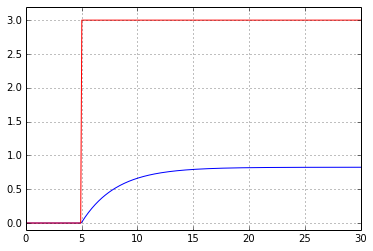

In [35]:
# Plot the stimulus and response
plt.plot(time, resp[1])
plt.hold(True)
plt.plot(time, u, "r-")
plt.ylim([-0.1, 3.2])
plt.grid(True)